In [6]:
%cd drive/MyDrive

[Errno 2] No such file or directory: 'drive/MyDrive'
/content/drive/MyDrive


In [ ]:
import os

pics = os.listdir('AlexNet-Keras-master/data/image/train/')

with open('AlexNet-Keras-master/data/dataset.txt', 'w') as f:
  for pic in pics:
    name = pic.split('.')[0]
    if name == 'cat':
      f.write(pic + ';0\n')
    elif name == 'dog':
      f.write(pic + ';1\n')
  f.close()

In [7]:
import matplotlib.image as mpimg
import numpy as np
import cv2
import tensorflow as tf

def resize_image(image, size):
    with tf.name_scope('resize_image'):
        images = []
        for i in image:
            i = cv2.resize(i, size)
            images.append(i)
        images = np.array(images)
        return images

def print_answer(argmax):
    with open("AlexNet-Keras-master/data/model/index_word.txt","r",encoding='utf-8') as f:
        synset = [l.strip().split(";")[1] for l in f.readlines()]

    print(synset[argmax])
    return synset[argmax]

In [8]:
from keras.models import Sequential
from keras.layers import Dense,Activation,Conv2D,MaxPooling2D,Flatten,Dropout,BatchNormalization

def AlexNet(input_shape=(224,224,3),output_shape=2):

  model = Sequential()

  model.add(
      Conv2D(
          filters=48,
          kernel_size=(11,11),
          strides=(4,4),
          padding='valid',
          input_shape=input_shape,
          activation='relu'
          ) # (55,55,48)
      )

  model.add(BatchNormalization())
  model.add(
      MaxPooling2D(
          pool_size=(3,3),
          strides=(2,2),
          padding='valid'
          ) # (27, 27, 48)
      )

  model.add(
      Conv2D(
          filters=128,
          kernel_size=(5,5),
          strides=(1,1),
          padding='same',
          activation='relu'
          ) # (27, 27, 128)
      )

  model.add(BatchNormalization())
  model.add(
      MaxPooling2D(
          pool_size=(3,3),
          strides=(2,2),
          padding='valid'
          ) # (13, 13, 128)
      )

  model.add(
      Conv2D(
          filters=192,
          kernel_size=(3,3),
          strides=(1,1),
          padding='same',
          activation='relu'
          ) # (13, 13, 192)
      )

  model.add(
      Conv2D(
          filters=192,
          kernel_size=(3,3),
          strides=(1,1),
          padding='same',
          activation='relu'
          ) # (13, 13, 192)
      )

  model.add(
      Conv2D(
          filters=128,
          kernel_size=(3,3),
          strides=(1,1),
          padding='same',
          activation='relu'
          ) # (13, 13, 192)
      )

  model.add(
      MaxPooling2D(
          pool_size=(3,3),
          strides=(2,2),
          padding='valid'
        ) # (6, 6, 192)
    )

  model.add(Flatten())
  model.add(Dense(1024, activation='relu'))
  model.add(Dropout(0.25))

  model.add(Dense(1024, activation='relu'))
  model.add(Dropout(0.25))

  model.add(Dense(output_shape, activation='softmax'))

  return model

In [ ]:
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras import backend as K
K.set_image_data_format('channels_last')

In [ ]:
def generate_arrays_from_file(lines,batch_size):

    n = len(lines)
    i = 0
    while 1:
        X_train = []
        Y_train = []

        for b in range(batch_size):
            if i==0:
                np.random.shuffle(lines)
            name = lines[i].split(';')[0]

            img = cv2.imread("AlexNet-Keras-master/data/image/train" + '/' + name)
            img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
            img = img/255
            X_train.append(img)
            Y_train.append(lines[i].split(';')[1])

            i = (i+1) % n

        X_train = resize_image(X_train, (224,224))
        X_train = X_train.reshape(-1,224,224,3)
        Y_train = to_categorical(np.array(Y_train),num_classes = 2)
        yield (X_train, Y_train)

In [ ]:
log_dir = "AlexNet-Keras-master/logs/"

with open("AlexNet-Keras-master/data/dataset.txt","r") as f:
  lines = f.readlines()

  np.random.seed(10101)
  np.random.shuffle(lines)
  np.random.seed(None)

  num_val = int(len(lines)*0.1)
  num_train = len(lines) - num_val

  model = AlexNet()

  checkpoint_period = ModelCheckpoint(
      log_dir + 'ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5',
      monitor='accuracy',
      save_weights_only=False,
      save_best_only=True,
      period=3)

  reduce_lr = ReduceLROnPlateau(
      monitor='accuracy',
      factor=0.5,
      patience=3,
      verbose=1)

  early_stopping = EarlyStopping(
      monitor='val_loss',
      min_delta=0,
      patience=10,
      verbose=1)

  model.compile(loss = 'categorical_crossentropy',
            optimizer = Adam(lr=1e-3),
            metrics = ['accuracy'])


  batch_size = 128

  print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))

  model.fit_generator(generate_arrays_from_file(lines[:num_train], batch_size),
                      steps_per_epoch=max(1, num_train//batch_size),
                      validation_data=generate_arrays_from_file(lines[num_train:], batch_size),
                      validation_steps=max(1, num_val//batch_size),
                      epochs=30,
                      initial_epoch=0,
                      callbacks=[checkpoint_period, reduce_lr])

  model.save_weights(log_dir+'last1.h5')

<ipython-input-8-f84a45b2df90>:43: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generate_arrays_from_file(lines[:num_train], batch_size),


Train on 22500 samples, val on 2500 samples, with batch size 128.
Epoch 1/30
175/175 [==============================] - 8391s 48s/step - loss: 0.8044 - accuracy: 0.5075 - val_loss: 0.6931 - val_accuracy: 0.5021 - lr: 0.0010
Epoch 2/30
175/175 [==============================] - 169s 973ms/step - loss: 0.6933 - accuracy: 0.4974 - val_loss: 0.6932 - val_accuracy: 0.4992 - lr: 0.0010
Epoch 3/30
175/175 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.5000

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


175/175 [==============================] - 172s 990ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5045 - lr: 0.0010
Epoch 4/30
175/175 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.4992
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
175/175 [==============================] - 176s 1s/step - loss: 0.6932 - accuracy: 0.4992 - val_loss: 0.6931 - val_accuracy: 0.5045 - lr: 0.0010
Epoch 5/30
175/175 [==============================] - 182s 1s/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5058 - lr: 5.0000e-04
Epoch 6/30
175/175 [==============================] - 156s 894ms/step - loss: 0.6932 - accuracy: 0.4923 - val_loss: 0.6931 - val_accuracy: 0.5053 - lr: 5.0000e-04
Epoch 7/30
175/175 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.5009
Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
175/175 [==============================]

1/1 [==============================] - 0s 177ms/step
猫


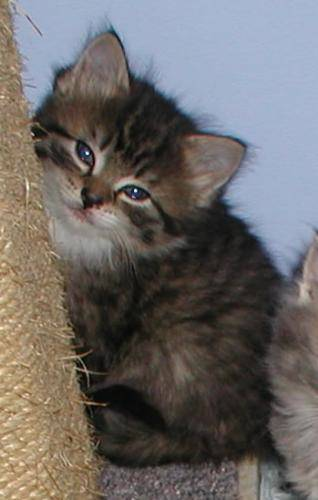

In [19]:
from google.colab.patches import cv2_imshow

model = AlexNet()
model.load_weights("AlexNet-Keras-master/logs/ep030-loss0.030-val_loss0.547.h5")
img = cv2.imread("AlexNet-Keras-master/Test.jpg")
img_RGB = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img_nor = img_RGB/255
img_nor = np.expand_dims(img_nor,axis = 0)
img_resize = resize_image(img_nor,(224,224))
print_answer(np.argmax(model.predict(img_resize)))
cv2_imshow(img)
#cv2.waitKey(0)